In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Load and combine day 0–2 with proper timestamp offsets
data_dir = "../data/round-3-island-data-bottle"
offsets = {0: 0, 1: 1_000_000, 2: 2_000_000}
all_data = []

for day in [0, 1, 2]:
    file_path = os.path.join(data_dir, f"prices_round_3_day_{day}.csv")
    if not os.path.exists(file_path):
        print(f"WARNING: Missing {file_path}")
        continue
    df_day = pd.read_csv(file_path, sep=';')
    df_day['timestamp'] += offsets[day]

    # Calculate mid prices and spreads
    for i in [1, 2, 3]:
        df_day[f'ask_price_{i}'] = df_day[f'ask_price_{i}'].replace(0, np.nan)
        df_day[f'bid_price_{i}'] = df_day[f'bid_price_{i}'].replace(0, np.nan)
        df_day[f'mid_price_{i}'] = np.where(
            df_day[f'bid_price_{i}'].notna() & df_day[f'ask_price_{i}'].notna(),
            (df_day[f'bid_price_{i}'] + df_day[f'ask_price_{i}']) / 2,
            np.nan
        )
        df_day[f'spread_{i}'] = df_day[f'ask_price_{i}'] - df_day[f'bid_price_{i}']

    df_day['mid_price'] = df_day['mid_price_1']
    df_day['spread'] = df_day['spread_1']
    df_day = df_day[(df_day['spread'] <= 10) & df_day['spread'].notna()]
    df_day.dropna(subset=['mid_price'], inplace=True)

    all_data.append(df_day)

combined = pd.concat(all_data).sort_values(by='timestamp').reset_index(drop=True)

# Separate underlying and options
df_underlying = combined[combined['product'] == 'VOLCANIC_ROCK'].copy()
df_options = combined[combined['product'] != 'VOLCANIC_ROCK'].copy()

# Extract strike
def extract_strike(product):
    parts = product.split('_')
    return float(parts[-1]) if parts[-1].isdigit() else np.nan

df_options['K'] = df_options['product'].apply(extract_strike)
df_options.dropna(subset=['K'], inplace=True)

# Merge with underlying prices
df_underlying = df_underlying[['timestamp', 'mid_price']].rename(columns={'mid_price': 'St'})
df = pd.merge(df_options, df_underlying, on='timestamp', how='inner')
df = df.rename(columns={'mid_price': 'Vt'})

# Compute TTE using formula: TTE = ((8 - round) - timestamp / 1M) / 365
df['TTE'] = ((8 - 3) - df['timestamp'] / 1_000_000) / 365
df = df[(df['Vt'] > 0) & (df['St'] > 0) & (df['K'] > 0)].copy()

# --- Black-Scholes ---
def bs_call_price(S, K, T, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return max(0.0, S - K)
    d1 = (np.log(S / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

def implied_volatility(V, S, K, T):
    if V <= 0 or S <= 0 or K <= 0 or T <= 0:
        return np.nan
    def objective(sigma):
        return bs_call_price(S, K, T, sigma) - V
    try:
        result = root_scalar(objective, bracket=[1e-4, 5.0], method='brentq')
        return result.root if result.converged else np.nan
    except:
        return np.nan

# Calculate moneyness m_t and implied volatility v_t
df['m_t'] = np.log(df['K'] / df['St']) / np.sqrt(df['TTE'])
df['v_t'] = df.apply(lambda row: implied_volatility(row['Vt'], row['St'], row['K'], row['TTE']), axis=1)
df.dropna(subset=['m_t', 'v_t'], inplace=True)
df = df[(df['v_t'] >= 0.001) & (df['v_t'] <= 1.0)]

# Fit and print parabolic curve
coeffs = np.polyfit(df['m_t'], df['v_t'], 2)
vol_curve = np.poly1d(coeffs)
a, b, c = coeffs
print(f"Fitted volatility curve: v(m) = {a:.4f} * m^2 + {b:.4f} * m + {c:.4f}")
print(f"Baseline IV at m=0 (ATM): {vol_curve(0):.4f}")

# Plot smile
m_range = np.linspace(df['m_t'].min(), df['m_t'].max(), 300)
plt.figure(figsize=(10, 6))
for strike in sorted(df['K'].unique()):
    sub = df[df['K'] == strike]
    plt.scatter(sub['m_t'], sub['v_t'], s=2, alpha=0.4, label=f'Strike {int(strike)}')

plt.plot(m_range, vol_curve(m_range), color='red', linewidth=2, label='Fitted v(m)')
plt.title("Implied Volatility Smile (Days 0–2)")
plt.xlabel("Moneyness (m)")
plt.ylabel("Implied Volatility (v)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: Plot Baseline IV (v(m=0)) over time ---
df['base_iv'] = vol_curve(0)
df_iv_curve = df.groupby('timestamp')['base_iv'].mean().reset_index()
plt.figure(figsize=(10, 4))
plt.plot(df_iv_curve['timestamp'], df_iv_curve['base_iv'], label='Fitted ATM IV', color='blue')
plt.title('Baseline IV (ATM) over Time')
plt.xlabel('Timestamp')
plt.ylabel('IV at m=0')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


ValueError: No objects to concatenate

In [2]:
from tqdm import tqdm

base_iv_series = []

timestamps = sorted(df['timestamp'].unique())

for ts in tqdm(timestamps):
    subset = df[df['timestamp'] == ts]
    if len(subset) < 5:
        continue  # Too few data points to fit a parabola
    try:
        coeffs = np.polyfit(subset['m_t'], subset['v_t'], 2)
        atm_iv = np.poly1d(coeffs)(0)
        base_iv_series.append((ts, atm_iv))
    except:
        continue

df_base_iv = pd.DataFrame(base_iv_series, columns=['timestamp', 'base_iv'])


100%|██████████| 29362/29362 [00:35<00:00, 832.82it/s] 


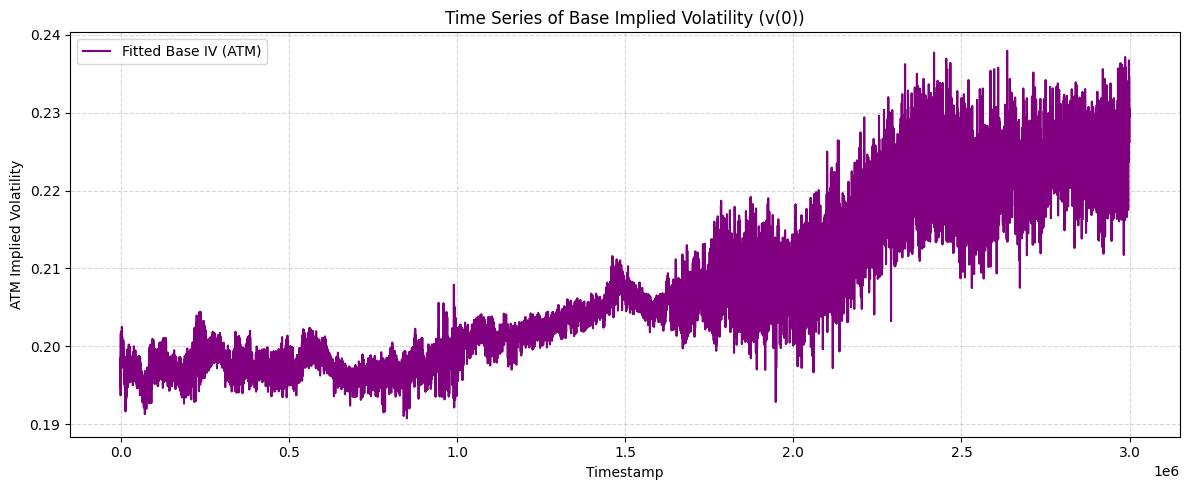

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(df_base_iv['timestamp'], df_base_iv['base_iv'], color='purple', label='Fitted Base IV (ATM)')
plt.xlabel('Timestamp')
plt.ylabel('ATM Implied Volatility')
plt.title('Time Series of Base Implied Volatility (v(0))')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
